In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## 1. Data collection

### 1.1. Get the list of places

In [ ]:
# import library

from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import re
import requests

In [ ]:
f = open("urls.txt","w")

for k in range(1,401):
    
    page = requests.get("https://www.atlasobscura.com/places?page="+str(k)+'&sort=likes_count') # select the page
    soup = BeautifulSoup(page.content, features="lxml") # take the content from the page


    links = []
    for link in soup.findAll('a'):
        links.append(link.get('href'))

    while(len(links)>30):

        #remove None values
        while(None in links):
            links.remove(None)


        #clean list
        while('/places/new' in links):
            links.remove('/places/new')


        #remove urls from places in different categories
        for link in links:

    
            if (link[:8]!='/places/'):
                links.remove(link)

    if ("/places/" not in links[-1]): links.pop()


    links = links[9:] #remove urls from places in different categories

    for i in range(len(links)):

        links[i] = 'https://www.atlasobscura.com' + links[i] +'\n'

        f.write(links[i])

f.close()

### 1.2. Crawl places

In [ ]:
with open('urls.txt') as fh:
    all_links = fh.read().split('\n')

cont_pages = 0
name_pages = 0
cont_folder = 1 

#create directory if not already present
if not os.path.exists('folder{}'.format(str(cont_folder))):
    os.mkdir('folder{}'.format(str(cont_folder)))
    
    
for line in all_links:
    if cont_pages > 18:
        cont_folder += 1
        os.mkdir('folder{}'.format(str(cont_folder)))
        cont_pages = 0

    print("LINE: " +line)
    HTML = requests.get(line, allow_redirects=False, timeout=3) #request html
    soup = bs4.BeautifulSoup(HTML.content, features="lxml")
    
    #write html
    with open(str('folder{}'.format(str(cont_folder)))+'/place'+str(name_pages)+'.txt', 'w') as f:
        f.write(str(soup.prettify()))
        f.close()
        cont_pages += 1
        name_pages += 1

### 1.3 Parse downloaded pages

extract_info is a function that when inputted a single html file it will clean and extract
the necessary informations, appending them to the corresponding lists, so that we can unite
everything in a tsv file.

In [ ]:
#when it blocks remember to eleminate the elements if you restart from a certain point
placeName = []
placeTags = []
numPeopleVisited = []
numPeopleWant = []
placeDesc = []
placeShortDesc = []
placeNearby = []
placeAddress = []
placeAlt = []
placeLong = []
placeEditors = []
placePubDate = []
placeRelatedLists = []
placeRelatedPlaces = []
placeURL = []

In [ ]:
def extract_info(html):
    soup = bs4.BeautifulSoup(html)
    
    try:
        placeName.append(soup.find_all('h1', {'class' : 'DDPage__header-title'})[0].contents[0])
    except:
        placeName.append('')
    #place tags        
    placeTags1 = [x.text for x in soup.find_all('span',{'class':'itemTags__tag js-item-tags-tag itemTags__tag--light itemTags__tag--rounded'})]
    try:            
        placeTags.append([x.replace('\n','') for x in placeTags1])
    except:
        placeTags.append('')
    
    #N of people who visited
    try:
        numPeopleVisited.append(int(soup.find_all('div', {'class' : "title-md item-action-count"})[0].contents[0]))
    except:
        numPeopleVisited.append('')
    
    #number of people who want to go
    try:
        numPeopleWant.append(int(soup.find_all('div', {'class' : "title-md item-action-count"})[1].contents[0]))
    except:
        numPeopleWant.append('')
        
    #full description
    try:
        long_desc = [x.text for x in soup.find_all('div',{'id':'place-body'})]
        clean_desc = [x.replace('\n','') for x in long_desc]
        placeDesc.append(clean_desc)
    except:
        placeDesc.append('')
    
    #short description of the place
    try:
        placeShortDesc.append(soup.find_all('h3', {'class' : 'DDPage__header-dek'})[0].contents[0])
    except:
        placeShortDesc.append('')
        
    #the nearby places
    try:
        placeNearby.append([x.text for x in soup.find_all('div', {'class' : 'DDPageSiderailRecirc__item-title'})])
    except:
        placeNearby.append('')
        
    #address of the place
    try:
        placeA =[x.text for x in soup.find_all('address', {'class' : 'DDPageSiderail__address'})]
        placeAd = [x.replace('\n','') for x in placeA]
        placeAddress.append(placeAd[0])
    except:
        placeAddress.append('')

    #finding the coordinates of the place        
    try:
        #this creates a list and divides the coordinates in Altitude & longitude
        placeAlt1 = [x.get('data-coordinates') for x in soup.find_all('div',{'class':'DDPageSiderail__coordinates js-copy-coordinates'})]
        newAlt = [coordinates.replace(',','') for string in placeAlt1 for coordinates in string.split()]
    
        placeAlt.append(float(newAlt[0]))
        placeLong.append(float(newAlt[1]))
    except:
        placeAlt.append('')
        placeLong.append('')
    
    #finding the editors for the page
    try:
        editors = [x.text for x in soup.find_all('a',{'class':'DDPContributorsList__contributor'})]
        editors_clean = [x.replace('\n','') for x in editors]
        placeEditors.append(editors_clean)
    except:
        placeEditors.append('')
    
    #date of pubblication of the post
    try:
        Date = soup.find_all('div', {'class' : "DDPContributor__name"})[0].contents[0]
        placePubDate1 = Date.replace(',','')
        placePubDate.append(datetime.strptime(placePubDate1,'%B %d %Y'))
    except:
        placePubDate.append('')
    
    #Lists the place was included to
    try:
        placeRL1 = [x.text for x in soup.find_all('h3',{'class':'Card__heading --content-card-v2-title js-title-content'})]
        placeRL = [x.replace('\n', '') for x in placeRL1]
        lun = len(placeRL)
        placeRelatedLists.append(placeRL[lun-2:lun])
    except:
        placeRelatedLists.append('')
        
    #names of the related places
    try:
        placeRL1 = [x.text for x in soup.find_all('h3',{'class':'Card__heading --content-card-v2-title js-title-content'})]
        placeRL = [x.replace('\n', '') for x in placeRL1]
        placeRelatedPlaces.append(placeRL[0:3])
    except:
        placeRelatedPlaces.append('')
        
    #the URL of the place
    try:
        url = [x.get('href') for x in soup.find_all('link', {'rel' : 'canonical'})]
        placeURL.append(url[0])
    except:
        placeURL.append('')

create dìthe directory for the tsv files

In [ ]:
os.makedirs('tsv_files')

we now need to write a function that creates the tsv files.

In [ ]:
def tsv_files(i):
    
    #naming the columns in the tsv file
    tsv_columns = ['placeName', 'placeTags', 'numPeopleVisited','numPeopleWant','placeDesc',
                  'placeShortDesc','placeNearby','placeAddress','placeAlt','placeLong','placeEditors',
                  'placePubDate','placeRelatedLists','placeRelatedPlaces','placeURL']
    #getting the row for each tsv file
    data = zip([placeName[cont-1]], [placeTags[cont-1]], [numPeopleVisited[cont-1]],[numPeopleWant[cont-1]],[placeDesc[cont-1]],
                  [placeShortDesc[cont-1]],[placeNearby[cont-1]],[placeAddress[cont-1]],[placeAlt[cont-1]],[placeLong[cont-1]],[placeEditors[cont-1]],
                  [placePubDate[cont-1]],[placeRelatedLists[cont-1]],[placeRelatedPlaces[cont-1]],[placeURL[cont-1]])
    #creating and opening the tsv file
    tsv_name = "tsv_files/place_" +str(i) + ".tsv"
    with open(tsv_name, encoding = 'utf-8', mode = 'w') as tsv_file:
        tsv_output = csv.writer(tsv_file, delimiter='\t')
        tsv_output.writerow(tsv_columns)
        for placeN, placeT, numP,numPW,placeD,placeSD,placeNear,placeAd,placeA,placeL,placeEd,placePubD,placeRL,placeRP,URL in data:
            tsv_output.writerow([placeN, placeT, numP,numPW,placeD,placeSD,placeNear,placeAd,placeA,placeL,placeEd,placePubD,placeRL,placeRP,URL])

In [ ]:
cont_pages = 0
cont_htmlcode = 0

for pages in tqdm(range(0,400)):
    for i in range(1,19):
        path = 'C:/Users/flavi/Homeworks/ADM-HW3/HTML/' + 'page{}'.format(str(pages)) + '/_/' + 'htmlcode{}'.format(str(i)) + '.html'
        f = open(path, encoding="utf8")
        extract_info(f)
        # calling the tsv create function to create tsv 
        tsv_files(cont_htmlcode)
        f.close()
        cont_htmlcode += 1

## 2. Search Engine

Now, we want to create two different Search Engines that, given as input a query, return the places that match the query.

First, you must pre-process all the information collected for each place by:

1. Removing stopwords
2. Removing punctuation
3. Stemming
4. Anything else you think it's needed

For this purpose, you can use the nltk library.

Import of the libraries that will be used

In [153]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import json
import numpy as np
import string
import pandas as pd
from tqdm import tqdm


The columns of interest were saved in two empty lists: PlaceName in place_name and PlaceDesc in place_desc.

Then, using the zip function, tuples were created between the two lists so that they could later be converted into a DataFrame (places_final_df)

In [154]:
place_name = []
place_desc = []

for i in range(0, 7199):
    places = open('TSV/place_' +str(i+1)+'.tsv','r',encoding="utf8")
    
    place_info=pd.read_table(places)[['placeName','placeDesc']]

    place_info.placeName = place_info.placeName.astype(str)
    
    place_info.placeDesc = place_info.placeDesc.astype(str)
  
    place_name.append(str(place_info.placeName[0]))

    place_desc.append(str(place_info.placeDesc[0]))

In [155]:
#lists to DataFrame using the zip function
places_tuples = list(zip(place_name,place_desc))

places_final_df = pd.DataFrame(places_tuples, columns=['place_name','place_desc'])

We used the nltk library to get the english stopwords (stopwords). Also, PorterStemmer was used for stemming. The function stemming is in charge of extracting all the words from the sentences and then apply the porter stemmer function to perform the stemming correctly.

In [156]:
stpwprds = stopwords.words('english')
por_stem = PorterStemmer()

def stemming(lines):

    separated_word = lines.split()

    stemmed_words = [por_stem.stem(word) for word in separated_word]

    return ' '.join(stemmed_words)

1. Removing Stopwords

In [157]:
places_final_df.place_desc = places_final_df.place_desc.apply(lambda x: ' '.join([word for word in x.split() if word not in (stpwprds)]))

2. Removing punctuation

In [158]:
#Regex was used to replace all characters that are not AlphaNumeric (\w) or Whitspace characters (\s)
places_final_df.place_desc = places_final_df.place_desc.str.replace('[^\w\s]',' ')


/var/folders/gy/6j7jtq4n7m36jvtq0tfc4t880000gn/T/ipykernel_990/99722946.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  places_final_df.place_desc = places_final_df.place_desc.str.replace('[^\w\s]',' ')


3. Stemming

In [159]:
#Using the function stemming defined previously
places_final_df.place_desc = places_final_df.place_desc.apply(stemming)

#### 2.1. Conjunctive query

For the first version of the search engine, we narrow our interest to the description of each place. It means that you will evaluate queries only concerning the place's description.

Note: You should use the longer description placeDesc column and not the short description placeShortDesc.

##### 2.1.1) Create your index!
Before building the index,

Create a file named vocabulary, in the format you prefer, that maps each word to an integer (term_id).

Then, the first brick of your homework is to create the Inverted Index. It will be a dictionary of this format:

{
term_id_1:[document_1, document_2, document_4],
term_id_2:[document_1, document_3, document_5, document_6],
...}

where document_i is the id of a document that contains that specific word.

Hint: Since you do not want to compute the inverted index every time you use the Search Engine, it is worth thinking about storing it in a separate file and loading it in memory when needed.


list of words (list_words) of each word that is going to use to create the vocabulary.

set() was used to remove duplicates

In [8]:
list_words  = ' '.join([word for word in places_final_df.place_desc]).split()

list_words_unique = set(list_words)

In the dictionary "vocabulary" all the unique words were saved with an id.

In [10]:

vocabulary = {}

i=1
for word in list_words_unique:
    
    vocabulary.update({i:word}) 
    
    i+=1


The vocabulary was stored in a JSON file. Then, we opened this JSON file and extract the key and value of the data objects (vocab_ob). If the vocabulary value is in the place description (the sentences were separated by a split), a name was added to the list_inv. Finally, the initial dictionary (dictionary_inv) is updated with the key and the inverted list that was created.



In [21]:
with open("vocab.json", "w") as file:
    
    json.dump(vocabulary, file)

file.close()

dictionary_inv = {}

with open('vocab.json') as vocab_file:  
    
    vocab_ob = json.load(vocab_file)
    
    for key, value in tqdm(vocab_ob.items()):
        
        list_inv = []

        for i in range(0,len(places_final_df)):
            
            if(value in places_final_df['place_desc'][i].split()): 
                place_name = 'place_'+str(i+1)
                list_inv.append(place_name)
                dictionary_inv.update({key:list_inv})

100%|██████████| 43478/43478 [1:05:49<00:00, 11.01it/s]


The result (dictionary inv) was saved in the JSON inv_indx. In this way, we don't have to compute the inverted index every time we use the Search Engine

In [22]:
with open("inv_indx.json", "w") as file:
    json.dump(dictionary_inv, file)
file.close()

##### 2.1.2) Execute the query

Given a query input by the user, for example:

american museum

The Search Engine is supposed to return a list of documents.

What documents do we want?
Since we are dealing with conjunctive queries (AND), each returned document should contain all the words in the query. The final output of the query must return, if present, the following information for each of the selected documents:

placeName

placeDesc

placeURL

If everything works well in this step, you can go to the next point and make your Search Engine more complex and better at answering queries.


The function query_input_text makes a first loop to search if the query text is found in the vocabulary. If the word that the user is looking for is found in the vocabulary, the inv_indx file is loaded and if the vocabulary key (key_vocab) and the inv_indx key (key_inv) match, we proceed to store the inv values ​​in the initial list (places_list)

In [160]:
def query_input_text(place_info_search):
    
    places_list = []
    
    for word in place_info_search:
        with open('vocab.json') as vocab_json:
            vocabulary = json.load(vocab_json)
            
            for key_vocab, value_vocab in vocabulary.items():
                
                if(word == value_vocab):
                    with open('inv_indx.json') as inv_indx:
                        inverted_info = json.load(inv_indx)
                        
                        for key_inv, value_inv in inverted_info.items():
                            
                            if(key_vocab == key_inv):
                                places_list.append(value_inv)
    return places_list
    

The result of the first function "places_list" is a list that contains all the places that match any of the searched words.

The function all_matches aims to return only the places that match ALL the words in the input search.

First, a unique list is created containing all places that matched the search, then duplicates are removed by converting the list to a dictionary.

Finally, a loop is made in which, for each place found, two things are compared: the length of the search words found in the vocabulary with the number of times that the place coincides with each search word found. If this comparison is equal, it means that every search word found in the vocabulary is in the place description.

In [161]:
def all_matches(places_list):
    places_list_all = []
    final_places_all_query_matches =[]
    
    for word_places_general in range(len(places_list)):
        for every_single_place in range(len(places_list[word_places_general])):
            places_list_all .append(places_list[word_places_general][every_single_place])

    place_unique = list(dict.fromkeys(places_list_all))

    for place in place_unique:
        if(len(places_list) == places_list_all.count(place)):
            final_places_all_query_matches.append(place)

    return final_places_all_query_matches

The function result_places_info will return a DataFrame that contains all the information required by the Search Engine: Place Name, Place Description and URL.

Through the for loop, the information of the places that mateched with ALL the previously searched words (places_unique_all_matches) was obtained.

The info lists are converted to tuples using zip function and then these tuples are converted to DataFrame.

As the example shown in the assignment had its information pre-processed, the description of the places is pre-processed.

In [162]:
def result_places_info(places_unique_all_matches):
    
    place_name= []
    place_desc = []
    place_url = []
    
    for place in places_unique_all_matches:
       
        info_places_all_tsv = open('TSV/' +place+ '.tsv','r',encoding="utf8")
        
        place_info = pd.read_table(info_places_all_tsv)[['placeName','placeDesc','placeURL']]
        
        place_info.placeName = place_info.placeName.astype(str)
    
        place_info.placeDesc = place_info.placeDesc.astype(str)

        place_info.placeURL = place_info.placeURL.astype(str)
  
        place_name.append(str(place_info.placeName[0]))

        place_desc.append(str(place_info.placeDesc[0]))

        place_url.append(str(place_info.placeURL[0]))

    place_url_final = [url[28:] for url in place_url]

    #lists to DataFrame using the zip function
    places_tuples = list(zip(place_name,place_desc,place_url_final))

    places_final_df_first_se = pd.DataFrame(places_tuples, columns=['place_name','place_desc','place_url_final'])

    #Pre-processing the final output

    places_final_df_first_se.place_desc = places_final_df_first_se.place_desc.apply(lambda x: ' '.join([word for word in x.split() if word not in (stpwprds)]))
    places_final_df_first_se.place_desc = places_final_df_first_se.place_desc.str.replace('[^\w\s]',' ')
    places_final_df_first_se.place_desc = places_final_df_first_se.place_desc.apply(stemming)
    
    return places_final_df_first_se

Search performed by the user. As all the information found in the description of the place is previously pre-processed, the same is done with the search text.

In [179]:
input_query = input('Search:')

input_query = ' '.join([word for word in input_query.split() if word not in stpwprds])
input_query = input_query.replace('[^\w\s]',' ')
input_query = stemming(input_query)

input_query_words = input_query.split()
#First function to get the matches
places_list = query_input_text(input_query_words)
#Second function to get only places that have all lookup values
places_unique_all_matches = all_matches(places_list)
#Final DF result
places_final_df_first_se = result_places_info(places_unique_all_matches)


/var/folders/gy/6j7jtq4n7m36jvtq0tfc4t880000gn/T/ipykernel_990/2176825905.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  places_final_df_first_se.place_desc = places_final_df_first_se.place_desc.str.replace('[^\w\s]',' ')


In [180]:
places_final_df_first_se

,place_name,place_desc,place_url_final
0,The Witch House of Salem,the salem witchcraft trial took place februari...,/places/witch-house-salem
1,Museum of the Weird,the dime dime store museum account endang spec...,/places/museum-weird
2,National Atomic Testing Museum,la vega oasi desert one sleep everi vice imagi...,/places/national-atomic-testing-museum
3,Canyons of the Ancients,ripe quiet reflect simpli awe inspir canyon an...,/places/canyons-of-the-ancients
4,The Natural Bridge,often cite place among great wonder natur worl...,/places/the-natural-bridge-natural-bridge-virg...
...,...,...,...
236,Bowling Ball Yard Art,updat octob 2020 some sculptur pictur longer v...,/places/bowling-ball-yard-art
237,Trees of Mystery,thi famili orient roadsid attract seen mile du...,/places/trees-of-mystery-2
238,De Vargas Street House,locat santa fe new mexico de varga street hous...,/places/de-vargas-street-house
239,Wilbur D. May Museum,there one place nevada find shrunken human hea...,/places/wilbur-d-may-museum


#### 2.2) Conjunctive query & Ranking score
For the second search engine, given a query, we want to get the top-k (the choice of k it's up to you!) documents related to the query. In particular:

Find all the documents that contain all the words in the query.

Sort them by their similarity with the query.

Return in output k documents, or all the documents with non-zero similarity with the query when the results are less than k. You must use a heap data structure (you can use Python libraries) for maintaining the top-k documents.

To solve this task, you must use the tfIdf score and the Cosine similarity. The field to consider is still the placeDesc. Let's see how.



##### 2.2.1) Inverted index

Your second Inverted Index must be of this format:

{
term_id_1:[(document1, tfIdf_{term,document1}), (document2, tfIdf_{term,document2}), (document4, tfIdf_{term,document4}), ...],
term_id_2:[(document1, tfIdf_{term,document1}), (document3, tfIdf_{term,document3}), (document5, tfIdf_{term,document5}), (document6, tfIdf_{term,document6}), ...],
...}

Practically, for each word, you want the list of documents in which it is contained and the relative tfIdf score.

Tip: TfIdf values are invariant for the query. Due to this reason, you can precalculate and store them accordingly.


term_frequency returns the number of times a word (term) appears in a document (doc). Every documents has its own term frequency.

Using the Regex Tokenizer we made a Counter about the tokens.

In [8]:
from collections import Counter

tokenizer = RegexpTokenizer(r'\w+')

def tokenize_and_count(text):
    tokens = tokenizer.tokenize(text)
    return Counter(tokens)

places_final_df["tokens_counter"] = places_final_df.place_desc \
    .apply(tokenize_and_count)

In [9]:
#Tokens count
places_final_df["tokens_count"] = places_final_df \
    .tokens_counter \
    .apply(lambda counter: np.sum(list(counter.values()), dtype=np.int64))

In [10]:
places_final_counts_df = pd.DataFrame({
        'token' : places_final_df['tokens_counter'].apply(lambda counter: counter.keys()),
        'count' : places_final_df['tokens_counter'].apply(lambda counter: counter.values())
    })

In [11]:
def term_frequency(term, place_id):
    
    count = places_final_df.tokens_counter[place_id - 1][term]
    len_doc = places_final_df.tokens_count[place_id - 1]
    
    return count/len_doc


doc_frequency returns the number of documents through a count (count) in which the term occurs.

In [12]:
grouped_places_final_counts_df = places_final_counts_df \
    .apply(pd.Series.explode) \
    .groupby(['token'])['count'].sum()

doc_frequency_dict = grouped_places_final_counts_df.to_dict()

In [13]:
def doc_frequency(term):

    if term not in doc_frequency_dict:
        print(f'term {term} is not in doc_frequency_dict, returning 0 as doc_frequency')
        return 0
    else:
        return doc_frequency_dict[term]
    

In the foor loop, "term" will save each word of the vocabulary and places related to each word (term) are saved in "places".

The number of places (place_id) is obtained and with this the TF-IDF begins to be calculated. The math library was used to calculate the inverse of the document frequency. Finally, the tfidf is obtained by multiplying the term_frequency with the inverse of the document frequency and it is stored in the i_dictionary that is for each item (place) and finally in tfidf_dict the TF-IDF of each place is stored.

In [14]:
with open("vocab.json") as vocab_json:
    vocabulary = json.load(vocab_json)
    vocab_json.close()

with open('inv_indx.json') as inv_indx:
    inverted_info = json.load(inv_indx)
    inv_indx.close()

In [15]:
import math

tfidf_dict = {}

len_places_final_df = len(places_final_df)

for i in tqdm(range(len(inverted_info))):

    list_tfidf = []
    
    term = vocabulary[str(i+1)]
    places = inverted_info[str(i+1)]

    doc_f = doc_frequency(term)

    if doc_f == 0:
        
        print(f'doc_frequency({term}) == 0, taking 0 as inv_doc_freq')
        inv_doc_freq = 0
   
    else:
        inv_doc_freq = math.log((len_places_final_df / doc_f + 1), 10)

    for place in places:

        place_id =(int(place.split("place_",1)[1]))

        term_f = term_frequency(term, place_id)

        tfidf = inv_doc_freq * term_f

        list_tfidf.append({place : tfidf})
    
    tfidf_dict.update({i+1:list_tfidf})



 68%|██████▊   | 29405/43478 [00:07<00:03, 3936.44it/s]

term i̇brahim is not in doc_frequency_dict, returning 0 as doc_frequency
doc_frequency(i̇brahim) == 0, taking 0 as inv_doc_freq


100%|██████████| 43478/43478 [00:11<00:00, 3925.42it/s]


The result (tfidf_dict) was saved in the JSON tfidf_final. In this way, we don't have to compute the inverted index every time we use the Search Engine #2.

In [17]:
with open("tfidf_final.json", "w") as file:
    json.dump(tfidf_dict, file)
file.close()

##### 2.2.2) Execute the query
In this new setting, given a query, you get the proper documents (i.e., those containing all the query's words) and sort them according to their similarity to the query. For this purpose, as the scoring function, we will use the Cosine Similarity concerning the tfIdf representations of the documents.

Given a query input by the user, for example:

american museum

The search engine is supposed to return a list of documents, ranked by their Cosine Similarity to the query entered in the input.

More precisely, the output must contain:

1. placeName
2. placeDesc
3. placeURL
4. The similarity score of the documents with respect to the query (float value between 0 and 1)

In [18]:
from collections import Counter
import re

cosine(v1,v2) is going to return the cosine between numerator calculation (num) and denominator calculation (den). 

inter is going to be the two vectors text intersection

In [53]:
def cosine(v1, v2):

    inter = set(v1.keys() & set(v2.keys()))

    num = sum([v1[x]*v2[x] for x in inter])

    lv1 = list(v1.keys())
    lv2 = list(v2.keys())

    vector_1_sum = sum([v1[x] ** 2 for x in lv1])

    vector_2_sum = sum([v2[x] ** 2 for x in lv2])

    den = math.sqrt(vector_1_sum) * math.sqrt(vector_2_sum)

    if not den:
        return 0
    else:
        cos_ans = float(num)/float(den)
        return cos_ans

vec_str is going to take a str value and convert it into a vector

In [76]:
def vec_str(text):

    WORD = re.compile(r"\w+")

    ans_text = WORD.findall(text)
    
    return Counter(ans_text)

input_query is the search carried out by the user, this search is pre-processed and all the places that match all the words in the search are obtained (places_final_df_first_se).

Then, the place number (place_id) from places_final_df_first_se was obtained in a list (list_place_id).

Finally, the result of the TF-IDF and the vocabulary were opened.

In [171]:
input_query = input('Search:')

input_query = ' '.join([word for word in input_query.split() if word not in stpwprds])
input_query = input_query.replace('[^\w\s]',' ')
input_query = stemming(input_query)

input_query_words = input_query.split()
WORD = re.compile(r"\w+")

#First function to get the matches
places_list = query_input_text(input_query_words)
#Second function to get only places that have all lookup values
places_unique_all_matches = all_matches(places_list)
#Final DF result
places_final_df_first_se = result_places_info(places_unique_all_matches)

list_place_id = []

for place in range(len(places_final_df)):
    for place_fse in range(len(places_final_df_first_se)):

        if(places_final_df_first_se.place_name[place_fse] == places_final_df.place_name[place]):
            list_place_id.append(place+1)


/var/folders/gy/6j7jtq4n7m36jvtq0tfc4t880000gn/T/ipykernel_990/2176825905.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  places_final_df_first_se.place_desc = places_final_df_first_se.place_desc.str.replace('[^\w\s]',' ')


In [172]:
with open("vocab.json") as vocab_json:
    vocabulary = json.load(vocab_json)
    vocab_json.close()

with open("tfidf_final.json") as tfidf_final_json:
    tfidf_ = json.load(tfidf_final_json)
    tfidf_final_json.close()

The function score_tfidf_ is going to return the  TF-IDF mean score (mean_score). Each word of the input search was obtained to perform the for loop. Each word (input_word) was searched for in the vocabulary and if it was found in the vocabulary, the match between the TF-IDF key and the key vocabulary was performed to obtain the score for each place. If the names matched, the place score was saved in the list: list_score_tfidf_.

Finally, the average TF-IDF score (mean_score) was obtained.

In [173]:
def score_tfidf_(input_query, place_id_):
    
    input_query_words = input_query.split()
    list_score_tfidf_ = []

    for word in input_query_words:

        for key_vocab, value_vocab in vocabulary.items():
             if(word == value_vocab):
                
                for key_tfidf, value_tfidf in tfidf_.items():
                    if(key_vocab ==key_tfidf):

                        for i in range(len(tfidf_[key_tfidf])):
                            
                            for key_tfidf_, value_tfidf_ in tfidf_[key_tfidf][i].items():
                                if(place_id_ == (int(key_tfidf_.split("place_",1)[1]))):
                                    list_score_tfidf_.append(value_tfidf_)
    
    mean_score = sum(list_score_tfidf_) / len(list_score_tfidf_) 
    return mean_score        

The function similarity is going to return the similarity score (between 0 and 1) list_score_similarity. First, it's going to iterate over the final data frame that contains the places that match all the words searched by the user (places_final_df_first_se). Then, the place desc is obtained to calculate the vectors of both, the place description and the input query. Finally, the Cosine is performed, we obtained the Mean TF-IDF score for each place that matches the user search and we obtained the Similarity score.

The Similarity column is attached to the DF of interest (places_final_df_first_se)

In [174]:
def similarity(list_place_id, input_query):

    list_score_similarity = []
    
    for i in range(len(places_final_df_first_se)):
        
        place_desc_ = places_final_df['place_desc'][list_place_id[i]-1]
       
        v1 = vec_str(input_query)
        v2 = vec_str(place_desc_)

        #Cosine
        cos_ans = cosine(v1, v2)
        #Mean TF-IDF score
        mean_score_ = score_tfidf_(input_query, list_place_id[i])
        #Similarity
        sim_score = mean_score_ *cos_ans
        list_score_similarity.append(sim_score)
   
    return list_score_similarity

In [176]:
list_score_similarity = similarity(list_place_id, input_query)

In [177]:
places_final_df_first_se['similarity'] = list_score_similarity

Finally, the data frame obtained is ordered taking into account the similarity by heapsort, as was required in the assignment, and we obtain the top 10.

In [178]:
places_final_df_first_se = places_final_df_first_se.sort_values('similarity', ascending = False, kind ='heapsort').head(10)

places_final_df_first_se

,place_name,place_desc,place_url_final,similarity
212,Lake Placid Murals,found 1992 lake placid mural societi fairli si...,/places/lake-placid-murals,0.011051
1,Museum of the Weird,the dime dime store museum account endang spec...,/places/museum-weird,0.009694
225,The Throne of the Third Heaven of the Nations'...,behold result one man rent garag scrap fourtee...,/places/the-throne-of-the-third-heaven-of-the-...,0.009023
27,Harvard Museum of Natural History,collect three differ institut one massiv museu...,/places/harvard-museum-of-natural-history,0.008505
147,The Senator,visit one oldest live organ world one point qu...,/places/the-senator-longwood-florida,0.007403
214,American Banjo Museum,contain instrument public display collect worl...,/places/american-banjo-museum,0.006973
94,Drayton Hall,consid one beauti exampl georgian palladian ar...,/places/drayton-hall,0.006267
104,U-505,one four remain u boat world u 505 fear fellow...,/places/u-505,0.006192
164,Laurinburg-Maxton Aircraft Boneyard,think aircraft boneyard might xa0pictur stretc...,/places/laurinburgmaxton-aircraft-boneyard,0.005920
59,Off the Rez Cafe,the u s govern s forc reloc nativ american com...,/places/off-the-rez-cafe,0.005801


## 3. Define a new score!

Now it's your turn. Build a new metric to rank places based on the queries of their users.

In this scenario, a single user can give input more information than a single textual query, so you need to consider all this information and think of a creative and logical way to answer the user's requests.

Practically:

    The user will enter a text query. As a starting point, get the query-related documents by exploiting the search engine of Step 3.1.

    Once you have the documents, you need to sort them according to your new score. In this step, you won't have any more to take into account just the plot of the documents; you must use the remaining variables in your dataset (or new possible variables that you can create from the existing ones). You must use a heap data structure (you can use Python libraries) for maintaining the top-k documents.

        Q: How to sort them? A: Allow the user to specify more information that you find in the documents and define a new metric that ranks the results based on the new request. You can also use other information regarding the place to score some places above others.

N.B.: You have to define a scoring function, not a filter!

The output, must contain:

    placeName
    placeDesc
    placeURL
    The new similarity score of the documents with respect to the query

Are the results you obtain better than with the previous scoring function? Explain and compare results.

The new score we decided is the following:


$$ \frac{similarity}{( \frac{1}{numPeopleVisit}+\frac{1}{numPeopleWant} )* 100}$$

The columns of interest from the TSV files are loaded.


In [187]:
def places_columns(list_place_id):
    
    place_numvisit= []
    place_numwant = []
    
    for place in list_place_id:
       
        info_places = open('TSV/place_' +str(place)+ '.tsv','r',encoding="utf8")

        columns_places =pd.read_table(info_places)[['numPeopleVisited','numPeopleWant']]

        columns_places.numPeopleVisited = columns_places.numPeopleVisited.astype(str)

        columns_places.numPeopleWant = columns_places.numPeopleWant.astype(str)

        place_numvisit.append(str(columns_places.numPeopleVisited[0]))

        place_numwant.append(str(columns_places.numPeopleWant[0]))
    
    return place_numvisit, place_numwant

Calculating the number of people visited weight and number of people who want to go wight:

In [182]:
def column_weight(place_numvisit, place_numwant):
    
    for place in range(len(place_numvisit)):
        
        place_numvisit[place] = 1/(float(place_numvisit[place]))
        place_numwant[place] = 1/(float(place_numwant[place]))
    
    return place_numvisit, place_numwant

Calculating the New score:

In [183]:
def new_score(result_similarity, weight_num_visit, weight_num_want):
    
    list_new_score = []

    for place in range(len(result_similarity)):

        new_score = result_similarity[place]/((weight_num_visit[place] + weight_num_want[place]) * 100)
        list_new_score.append(new_score)

    return list_new_score

Input search made by the user:

In [184]:
input_query = input('Search:')

input_query = ' '.join([word for word in input_query.split() if word not in stpwprds])
input_query = input_query.replace('[^\w\s]',' ')
input_query = stemming(input_query)

input_query_words = input_query.split()
#First function to get the matches
places_list = query_input_text(input_query_words)
#Second function to get only places that have all lookup values
places_unique_all_matches = all_matches(places_list)
#Final DF result
places_final_df_first_se = result_places_info(places_unique_all_matches)

#Obatining the place_id from the final result of the first search engine:
list_place_id = []
count=0

for place in range(len(places_final_df)):
    for place_fse in range(len(places_final_df_first_se)):

        if(places_final_df_first_se.place_name[place_fse] == places_final_df.place_name[place]):

            count= place+1
            list_place_id.append(count)

/var/folders/gy/6j7jtq4n7m36jvtq0tfc4t880000gn/T/ipykernel_990/2176825905.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  places_final_df_first_se.place_desc = places_final_df_first_se.place_desc.str.replace('[^\w\s]',' ')


Obatining the scores:

In [188]:
#Similarity Score
result_similarity = similarity(list_place_id, input_query)

#Number visited and Number Wanted columns
place_numvisit, place_numwant = places_columns(list_place_id)

#Weights
weight_num_visit, weight_num_want = column_weight(place_numvisit, place_numwant)

#New Score
list_new_score = new_score(result_similarity,weight_num_visit, weight_num_want)

The data frame obtained is ordered taking into account the new_score by heapsort, as was required in the assignment, and we obtain the top 10.

In [192]:
places_final_df_first_se['new_score'] = list_new_score

places_final_df_first_se = places_final_df_first_se.sort_values("new_score", ascending = False, kind ="heapsort").head(10)

In [193]:
places_final_df_first_se

,place_name,place_desc,place_url_final,new_score
1,Museum of the Weird,the dime dime store museum account endang spec...,/places/museum-weird,0.073182
27,Harvard Museum of Natural History,collect three differ institut one massiv museu...,/places/harvard-museum-of-natural-history,0.047643
59,Off the Rez Cafe,the u s govern s forc reloc nativ american com...,/places/off-the-rez-cafe,0.033783
90,Laurel Dinosaur Park,dure 18th 19th centuri clay format princ georg...,/places/laurel-dinosaur-park,0.031769
45,Frederick R. Weisman Art Museum,hous strike stainless steel brick build design...,/places/frederick-r-weisman-art-museum,0.027010
105,V. C. Morris Gift Shop,thi build maiden lane downtown san francisco c...,/places/v-c-morris-gift-shop,0.023937
15,Crazy Horse Memorial,when carv mount rushmor began 1927 local lakot...,/places/crazy-horse-memorial,0.020849
133,New Mexico Museum of Space History,most american familiar new mexico s place hist...,/places/new-mexico-museum-of-space-history,0.020044
66,Museum of Psychphonics,the museum psychphon modern day wunderkamm xa0...,/places/museum-of-psychphonics,0.019069
31,Thorne Miniature Rooms,in depth museum art institut chicago carpet ro...,/places/thorne-miniature-rooms,0.017880


As evidenced by the calculated New Score, the results obtained in the previous Search Engine that used only the Cosine Similarity are very similar to those obtained with the New Score. The difference in the Top 10 place is due to the number of people who have visited the place and the number of people who want to go there.

So this new score is going to be ideal for people who want to use a Search Engine based on the popularity of a place, understand popularity by favoritism of the place among people.

## 4. Visualizing the most relevant places

#### This are the results of question 3:

![title](Imgs/Q3res.png)

In [ ]:
import pandas as pd
import folium
from IPython.display import display, HTML

Locations with names and coordinates

In [ ]:
locations = pd.read_csv('Q4_locations.csv')
locations

We start creating the map

In [ ]:
world = folium.Map(location = [40,-97],zoom_start=4.9)

for i in range(10):

    curr=locations.loc[i]

    folium.Marker(
        location=[curr['longitude'], curr['latitude']],
        popup = curr['location_name']+'.\n'+curr['city']+','+curr['country'],
        tooltip = folium.Tooltip(permanent=True, text=curr['location_name']+'.\n'+curr['city']+','+curr['country'])
    ).add_to(world)

In [ ]:
def folium_deepnote_show(m): #function to show map
    data = m.get_root().render()
    data_fixed_height = data.replace('width: 100%;height: 100%', 'width: 100%').replace('height: 100.0%;', 'height: 609px;', 1)
    display(HTML(data_fixed_height))    

folium_deepnote_show(world)

![title](Imgs/Question_4_final_map.png)

We also put an image file of the produced map in the Imgs folder in any case

## 6.  Command line question

this question is visible in our main repository under the name:
commandline.sh

## 7. Theoretical question

### Data preparation

In [1]:
f = open("ApplicationsInfo.txt", 'r')

l = f.readline().split()

n_students = int(l[0])
n_grades = int(l[1])



#build dictionary where key : list of grades

d={}

for i in range(n_students):

    line = f.readline().split()

    if line==[]: break #means that we finished reading the textfile

    name = line[0]+' '+line[1]
    
    d[name] = line[2:]

#calculate grades average for each student

for line in d:

    avg = 0

    
    for i in range(n_grades):
        
        avg+=int(d[line][i])

    avg=round(float(avg/n_grades),2)

    d[line]=avg #update dictionary

print('ok avgs')
l_students = []
l_grades = []


#build list for student names and corresponfìding grades average

for key in d:

    l_students.append(key)

    l_grades.append(d[key])


ok avgs


### Algorithm1: Bubble sort

In [ ]:

def bubbleSort(grades, students):
    n = len(grades)

    swap = False
    
    #iterates through all array elements
    for i in range(n-1):
        
        # Last i elements are already in place
        for j in range(0, n-i-1):
 
            #swap if the element found is greater than the next element
            if grades[j] > grades[j + 1]:
                swap = True
                grades[j], grades[j + 1] = grades[j + 1], grades[j]
                students[j], students[j + 1] = students[j + 1], students[j]
         
        if not swap: #the array is sorted

            return


### Algorithm 2: Dynamic Insertion Sort

#### Pseudocode

create a list new_list 

for each $element$ of input list:

&nbsp;&nbsp;&nbsp;&nbsp; for each $element$ of new_list:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; insert element in new_list where (new_list[i-1] $\leq$ $element$ $\leq$ new_list[i+1])

return new_list

In [ ]:
#function to insert element in list at index
def list_insert(l, index, elem): #costs T(7) and Worst Space Complexity is O(n+1)
    
    temp1 = l[:index]
    temp2 = l[index:]
    
    out=[]
    
    if(temp1!=[]): out+=temp1
    
    out.append(elem)
    
    if(temp2!=[]): out+=temp2
    
    return out
    
    


def dynamicInsertion(grades,students):

    out_students=[]
    out_grades=[]
    
    out_students.append(students[0])
    out_grades.append(grades[0])

    for j in range(1,len(grades)): #O(N)

        for i in range(j): #O(log(N))
            
            if (i==0 and grades[j]<=out_grades[i]): #if the element is the smallest of the local output list
                
                
                out_grades = list_insert(out_grades, i, grades[j])
                out_students = list_insert(out_students,i,students[j])

                break
            
            elif (i==j-1 and grades[j]>=out_grades[i]):
                
                out_grades = list_insert(out_grades, i, grades[j])
                out_students = list_insert(out_students,i,students[j])
                
                break
            
            elif (grades[j]>=out_grades[i-1] and grades[j]<=out_grades[i]): #if the element is the greatest of the local output list

                out_grades = list_insert(out_grades, i, grades[j])
                out_students = list_insert(out_students,i,students[j])

                break
                
    return out_grades, out_students

### Algorithm 3: Merge Sort

In [ ]:
def mergeSort(grades,students):
    if len(grades) > 1:
 
        #middle of array
        mid = len(grades)//2
 
        #split into 2 halves
        left_g = grades[:mid] #diuviding grades array
        left_s = students[:mid] #dividing students array
 
        #split into 2 halves
        right_g = grades[mid:]
        right_s = students[mid:]
 
        #sort first half
        mergeSort(left_g, left_s)
 
        #sort second half
        mergeSort(right_g, right_s)
 
        i = j = k = 0
 
        #copy arrays to temp arrays left[] and right[]
        while i < len(left_g) and j < len(right_g):
            if left_g[i] <= right_g[j]:
                grades[k] = left_g[i]
                students[k] = left_s[i]
                i += 1
            else:
                grades[k] = right_g[j]
                students[k] = right_s[j]
                j += 1
            k += 1
 
        #check if any element was left
        while i < len(left_g):
            grades[k] = left_g[i]
            students[k] = left_s[i]
            i += 1
            k += 1
 
        while j < len(right_g):
            grades[k] = right_g[j]

            print(students,right_s)
            
            students[k] = right_s[j]
            j += 1
            k += 1

### Best and Worst case complexities

$Bubble Sort$: 

The Bubble Sort Algorithm has the fastest best case complexity of $O(N)$ as it has to perform N checks. This means the array is already sorted.
for worst case we get that both the internal and external loop are going to iterate $N$ times each, for a total time complexity of $O(N^2)$.

$Dynamic Insertion Sort$: 

For best case this algorithm also has to perform N checks, so it has a best case complexity of $O(N)$.
For worst case, assuming that the internal loop has time complexity of $O(log(N))$ because it's number of iterations goes from 1 to n for each iteration of the external loop, which also takes $N$ iterations. Complexity is $O(N \times log(N))$.

$Merge Sort$: 

The Merge Sort has the same complexity for best, average and worst case, which is always $O(N  log(N))$.

Keep in mind that worst case complexity is far more important than best case complexity.

### Running Times

In [3]:
import matplotlib.pyplot as plt

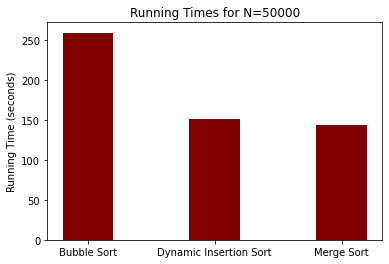

In [4]:
# creating the bar plot

algorithms = ['Bubble Sort', 'Dynamic Insertion Sort', 'Merge Sort']
times = [259.02, 151.49, 143.85]

plt.bar(algorithms,times, color ='maroon',
        width = 0.4)
 

plt.ylabel("Running Time (seconds)")
plt.title("Running Times for N=50000")
plt.show()

## Most optimal algorithm

The most optimal algorithm is Algorithm 3: Merge Sort for two reasons.

First, it has the lowest running time of 143.85 seconds and an asymptotycal time complexity of $O(N \times log(N))$ like the Dynamic Insertion Sort, but it also has a lower space complexity because it does not need to create an array of length N while the Dynamic Insertion Sort needs $O(N)$ space to output the sorted list.